1


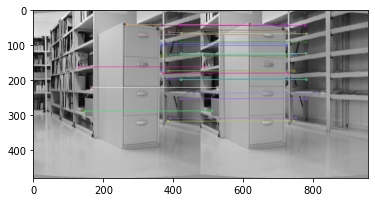

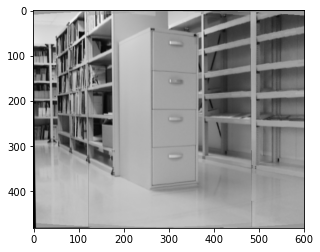

2


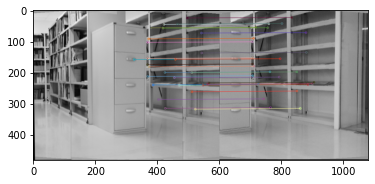

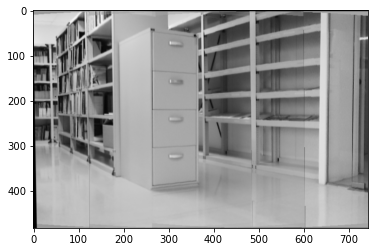

3


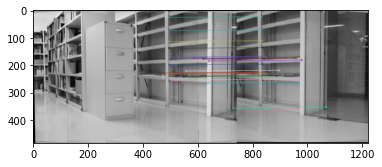

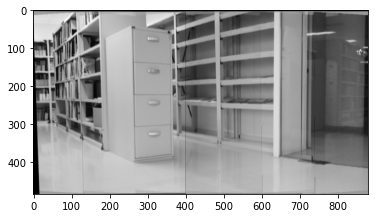

4


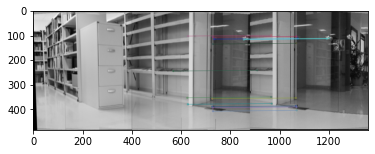

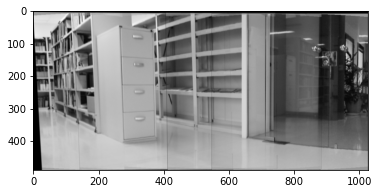

5


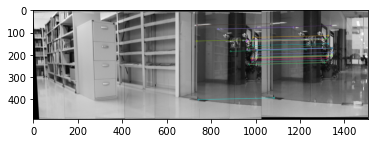

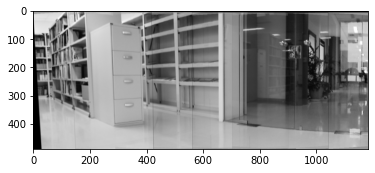

6


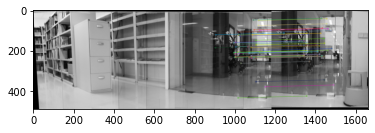

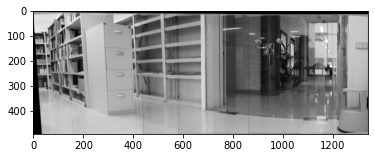

7


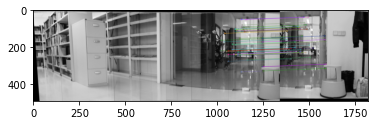

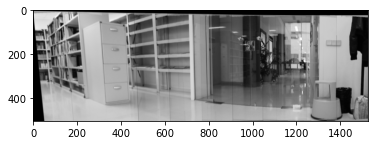

8


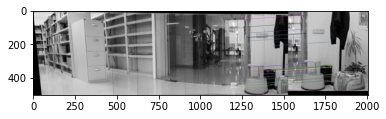

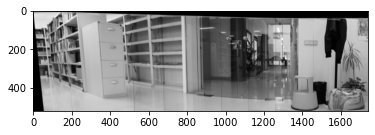

9


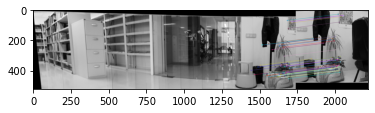

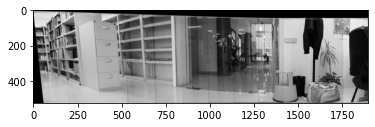

10


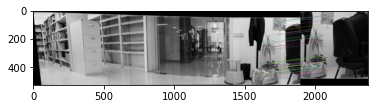

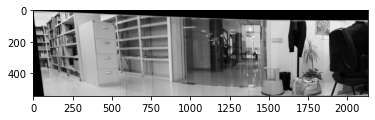

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import warnings
from scipy.spatial import distance
warnings.filterwarnings("ignore")

# Read file and return all images as array
def read_images(path):
    images_path = glob.glob(path)
    images_array = []
    for i in images_path:
        img = cv.imread(i)
        images_array.append(img)
    images_array = np.array(images_array)
    return images_array

# Using SIFT method to feature extraction then match features between two images
def extract_and_match_features(left_img, right_img):
    left_img = cv.cvtColor(left_img, cv.COLOR_RGB2GRAY)
    right_img = cv.cvtColor(right_img, cv.COLOR_RGB2GRAY)
    sift = cv.SIFT_create()
    left_kps, left_des = sift.detectAndCompute(left_img, None)
    right_kps, right_des = sift.detectAndCompute(right_img, None)
    dist = distance.cdist(left_des, right_des, 'sqeuclidean')
    left_des = np.where(dist < 7000)[0]
    right_des = np.where(dist < 7000)[1]
    left_points = np.array([left_kps[i].pt for i in left_des])
    right_points = np.array([right_kps[i].pt for i in right_des])
    matches = np.concatenate((left_points, right_points), axis=1)
    return matches

# Homography matrix calculation
def homography(matches):
    matrix = []
    for i in range(len(matches)):
        x1, y1 = matches[i][:2]
        x2, y2 = matches[i][2:4]
        matrix.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -x2 * y1, -x2])
        matrix.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    matrix = np.reshape(matrix, (-1, 9))
    vertical = np.linalg.svd(matrix)[2]
    vertical = vertical[len(vertical)-1].reshape(3, 3)
    homography_matrix = vertical / vertical[2, 2]
    return homography_matrix

# RANSAC method to calculate homography
def ransac(matches, threshold, max_iter):
    inl = []
    for i in range(max_iter):
        best_pairs = matches[np.random.choice(len(matches), 4, False)]
        h = homography(best_pairs)
        source = np.array([np.append(matches[i][:2], 1) for i in range(len(matches))]).T
        destination = matches[:, 2: 4]
        temp = np.array([row / row[2] for row in (np.dot(h, source)).T])[:, :2]
        err = np.linalg.norm(destination - temp, axis=1) ** 2
        location = np.where(err < threshold)[0]
        i = matches[location]
        if len(i) > len(inl):
            inl, histogram = i, h
    return inl, histogram

# Plot same key points between two images
def plot_inlines(left_img, right_img, matches):
    left_kps = matches[:, :2]
    right_kps = matches[:, 2:4]
    matches = [cv.DMatch(_imgIdx=0, _queryIdx=i, _trainIdx=i, _distance=0) for i in range(len(matches))]
    kp_left = [cv.KeyPoint(x=point[0], y=point[1], size=1) for point in left_kps]
    kp_right = [cv.KeyPoint(x=point[0], y=point[1], size=1) for point in right_kps]
    return_image = cv.drawMatches(left_img, kp_left, right_img, kp_right, matches, None)
    plt.imshow(return_image)
    plt.show()
    return return_image

def warp_to_l(image, homograph):
    x, y, z = image.shape
    vertices = [[0, 0], [y, 0], [y, x], [0, x]]
    vertices_new = []
    for vertice in vertices:
        vertice = np.append(np.array(vertice), 1)
        vertices_new.append(np.matmul(homograph, vertice))
    vertices_new = np.array(vertices_new).T
    min_x = min(vertices_new[0] / vertices_new[2])
    min_y = min(vertices_new[1] / vertices_new[2])
    translation_mat = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    homograph = np.dot(translation_mat, homograph)
    x_new = int(round(abs(min_y) + x))
    y_new = int(round(abs(min_x) + y))
    size = (y_new, x_new)
    warped_img = cv.warpPerspective(src=image, M=homograph, dsize=size)
    return warped_img, (min_x, min_y)

def move_to_r(image, move):
    p = move[0]
    q = move[1]
    new_move = np.array([[1, 0, -p], [0, 1, -q], [0, 0, 1]])
    x, y, z = image.shape
    x_new = int(round(abs(q) + x))
    y_new = int(round(abs(p) + y))
    s = (y_new, x_new)
    moved_img = cv.warpPerspective(src=image, M=new_move, dsize=s)
    return moved_img

def sew_image(left_image, right_image, homograph):
    action_l, move = warp_to_l(left_image, homograph)
    action_r = move_to_r(right_image, move)

    arr = np.zeros(3)
    for i in range(action_r.shape[0]):
        for j in range(action_r.shape[1]):
            l = action_l[i, j, :]
            r = action_r[i, j, :]

            if not np.array_equal(l, arr) and np.array_equal(r, arr):
                action_l[i, j, :] = l
            elif np.array_equal(l, arr) and not np.array_equal(r, arr):
                action_l[i, j, :] = r
            elif not np.array_equal(l, arr) and not np.array_equal(r, arr):
                action_l[i, j, :] = (l + r) / 2
            else:
                pass
    return action_l[:action_r.shape[0], :action_r.shape[1], :]

def plot_save_stitch(stitched, path):
    fig, ax = plt.subplots(figsize=(22, 11))
    ax.imshow(stitched)
    ax.axis('off')
    plt.show()

images = read_images('iiia06biblioteca-cyl-pano10\*')

#'iiia03actes-cyl-pano05\*'
#'iiia04actes-cyl-pano07\*'
#'iiia04actes-cyl-pano12\*'

left_image = images[0]

for i in range(0,10):
    right_image = images[i+1]
    print(i+1)
    matched_features = extract_and_match_features(left_image, right_image)
    inlines, H = ransac(matched_features, 0.3, 1000)
    ret = plot_inlines(left_image, right_image, inlines)

    image_color_left = cv.normalize(left_image.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
    image_color_right = cv.normalize(right_image.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
    sewed = sew_image(image_color_left, image_color_right, H)
    plt.imshow(sewed)
    plt.imsave("alp.png", sewed)
    plt.show()
    left_image = cv.imread("alp.png")